<a href="https://colab.research.google.com/github/Devendra379/HR-Employee-Attrition/blob/main/employee_attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandas numpy matplotlib seaborn

import pandas as pd

import numpy as np

# Importing important packages

In [2]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [4]:
df.shape

(1470, 35)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
df.isnull().sum()

,0
Age,0
Attrition,0
BusinessTravel,0
DailyRate,0
Department,0
DistanceFromHome,0
Education,0
EducationField,0
EmployeeCount,0
EmployeeNumber,0


In [7]:
# Engineer new features
df['YearsAtOtherCompanies'] = df['TotalWorkingYears'] - df['YearsAtCompany']
df['YearsAtOtherCompanies'] = df['YearsAtOtherCompanies'].apply(lambda x: max(x, 0))
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,80,0,8,0,1,6,4,0,5,2
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,80,1,10,3,3,10,7,1,7,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,80,0,7,3,3,0,0,0,0,7
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,80,0,8,3,3,8,7,3,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,80,1,6,3,3,2,2,2,2,4


In [8]:
df['SatisfactionLevel'] = df['JobSatisfaction'] + df['EnvironmentSatisfaction'] + df['RelationshipSatisfaction']
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies,SatisfactionLevel
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,2,7
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,0,9
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,7,3,3,0,0,0,0,7,9
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,0,10
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,4,7


In [9]:
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

In [10]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies,SatisfactionLevel
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,0,8,0,1,6,4,0,5,2,7
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,1,10,3,3,10,7,1,7,0,9
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,7,3,3,0,0,0,0,7,9
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,8,3,3,8,7,3,0,0,10
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,1,6,3,3,2,2,2,2,4,7


In [11]:
df['AgeBucket'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s'])
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies,SatisfactionLevel,AgeBucket
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,8,0,1,6,4,0,5,2,7,40s
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,10,3,3,10,7,1,7,0,9,40s
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,7,3,3,0,0,0,0,7,9,30s
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,8,3,3,8,7,3,0,0,10,30s
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,6,3,3,2,2,2,2,4,7,20s


In [12]:
df['CareerProgress'] = df['JobLevel'] / (df['TotalWorkingYears'] + 1)
df['StabilityIndex'] = df['YearsInCurrentRole'] / (df['YearsAtCompany'] + 1)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies,SatisfactionLevel,AgeBucket,CareerProgress,StabilityIndex
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,6,4,0,5,2,7,40s,0.222222,0.571429
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,3,10,7,1,7,0,9,40s,0.181818,0.636364
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,3,0,0,0,0,7,9,30s,0.125000,0.000000
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,8,7,3,0,0,10,30s,0.111111,0.777778
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,3,2,2,2,2,4,7,20s,0.142857,0.666667


In [13]:
df['AvgTenurePerCompany'] = df['TotalWorkingYears'] / (df['NumCompaniesWorked'] + 1)
df['IsHopper'] = df['AvgTenurePerCompany'] < 2
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies,SatisfactionLevel,AgeBucket,CareerProgress,StabilityIndex,AvgTenurePerCompany,IsHopper
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,4,0,5,2,7,40s,0.222222,0.571429,0.888889,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,7,1,7,0,9,40s,0.181818,0.636364,5.000000,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,0,0,7,9,30s,0.125000,0.000000,1.000000,True
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,7,3,0,0,10,30s,0.111111,0.777778,4.000000,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,2,2,2,4,7,20s,0.142857,0.666667,0.600000,True


In [14]:
df['IsRecentJoiner'] = df['YearsAtCompany'] < 1

In [15]:
df['IsHopper_RecentJoiner'] = df['IsHopper'] & df['IsRecentJoiner']

In [16]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

In [17]:
travel_map = {
    'Non-Travel': 0,
    'Travel_Rarely': 1,
    'Travel_Frequently': 2
}
df['BusinessTravel'] = df['BusinessTravel'].map(travel_map)

In [18]:
age_map = {
    '20s': 1,
    '30s': 2,
    '40s': 3,
    '50s': 4,
    '60s': 5
}
df['AgeBucket'] = df['AgeBucket'].map(age_map)


In [19]:
df = pd.get_dummies(df, columns=['Department'], drop_first=True)

In [20]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,SatisfactionLevel,AgeBucket,CareerProgress,StabilityIndex,AvgTenurePerCompany,IsHopper,IsRecentJoiner,IsHopper_RecentJoiner,Department_Research & Development,Department_Sales
0,41,1,1,1102,1,2,Life Sciences,1,1,2,...,7,3,0.222222,0.571429,0.888889,True,False,False,False,True
1,49,0,2,279,8,1,Life Sciences,1,2,3,...,9,3,0.181818,0.636364,5.000000,False,False,False,True,False
2,37,1,1,1373,2,2,Other,1,4,4,...,9,2,0.125000,0.000000,1.000000,True,True,True,True,False
3,33,0,2,1392,3,4,Life Sciences,1,5,4,...,10,2,0.111111,0.777778,4.000000,False,False,False,True,False
4,27,0,1,591,2,1,Medical,1,7,1,...,7,1,0.142857,0.666667,0.600000,True,False,False,True,False


In [21]:
# Step 1: Convert True/False to int
df_clean = df.copy()
bool_cols = df_clean.select_dtypes(include='bool').columns
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

# Step 2: Drop non-numeric columns (like 'AgeBucket', 'EducationField', etc.)
df_numeric = df_clean.select_dtypes(include=['number'])

# Step 3: Fill any remaining NaNs
df_numeric = df_numeric.fillna(0)

In [22]:
correlation_with_attrition = df_numeric.corr()['Attrition'].sort_values(key=abs, ascending=False)
print(correlation_with_attrition)

Attrition                            1.000000
OverTime                             0.246118
IsHopper                             0.225567
TotalWorkingYears                   -0.171063
CareerProgress                       0.170989
JobLevel                            -0.169105
YearsInCurrentRole                  -0.160545
MonthlyIncome                       -0.159840
Age                                 -0.159205
StabilityIndex                      -0.157625
YearsWithCurrManager                -0.156199
AvgTenurePerCompany                 -0.150500
SatisfactionLevel                   -0.146819
StockOptionLevel                    -0.137145
YearsAtCompany                      -0.134392
JobInvolvement                      -0.130016
BusinessTravel                       0.127006
IsHopper_RecentJoiner                0.120874
JobSatisfaction                     -0.103481
EnvironmentSatisfaction             -0.103369
IsRecentJoiner                       0.096686
Department_Research & Development 

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

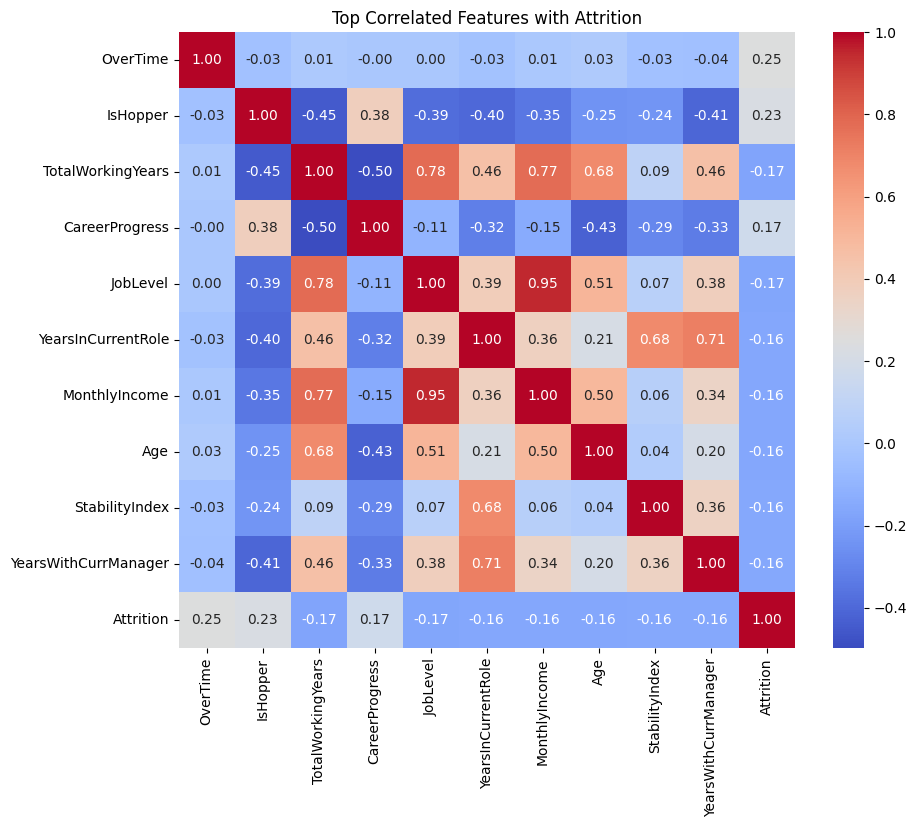

In [24]:
# Step 1: Calculate correlation with target
correlation_matrix = df_numeric.corr()
target_corr = correlation_matrix["Attrition"].drop("Attrition")  # Drop self-correlation

# Step 2: Select top N absolute correlations
top_features = target_corr.abs().sort_values(ascending=False).head(10).index.tolist()

# Step 3: Subset the correlation matrix with only top features + 'Attrition'
selected_features = top_features + ['Attrition']
filtered_corr = df_numeric[selected_features].corr()

# Step 4: Plot filtered heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Top Correlated Features with Attrition")
plt.show()

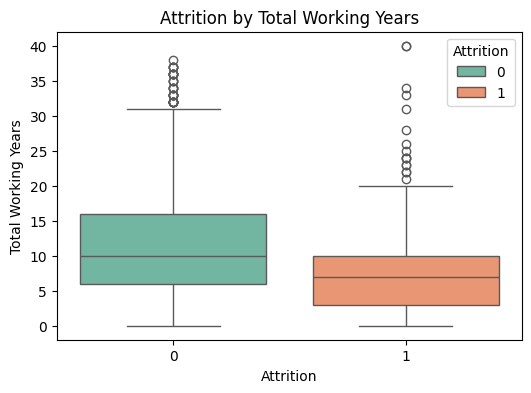

In [25]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Attrition', y='TotalWorkingYears', data=df, hue = 'Attrition', palette='Set2')
plt.title('Attrition by Total Working Years')
plt.xlabel('Attrition')
plt.ylabel('Total Working Years')
plt.show()

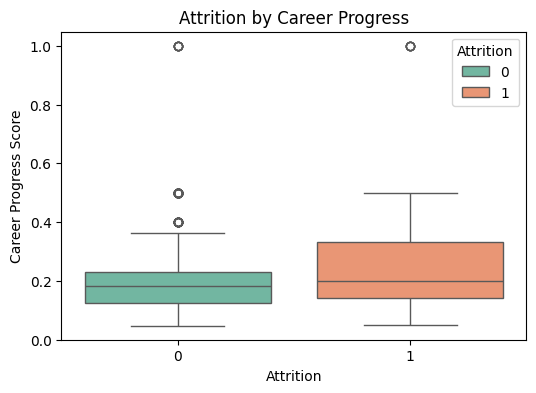

In [26]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Attrition', y='CareerProgress', hue = 'Attrition', data=df, palette='Set2')
plt.title('Attrition by Career Progress')
plt.xlabel('Attrition')
plt.ylabel('Career Progress Score')
plt.show()

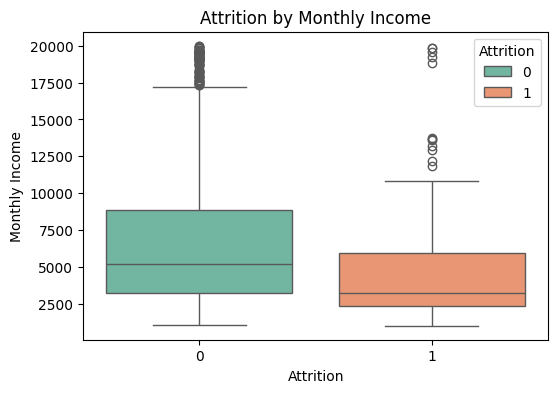

In [27]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df, palette='Set2', hue = 'Attrition')
plt.title('Attrition by Monthly Income')
plt.xlabel('Attrition')
plt.ylabel('Monthly Income')
plt.show()

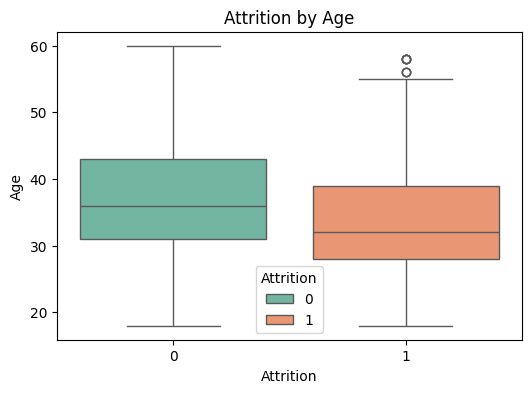

In [28]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Attrition', y='Age', data=df, palette='Set2', hue = 'Attrition')
plt.title('Attrition by Age')
plt.xlabel('Attrition')
plt.ylabel('Age')
plt.show()

/tmp/ipython-input-29-3086184073.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='BusinessTravel', y='Attrition', data=df, palette='Set3')


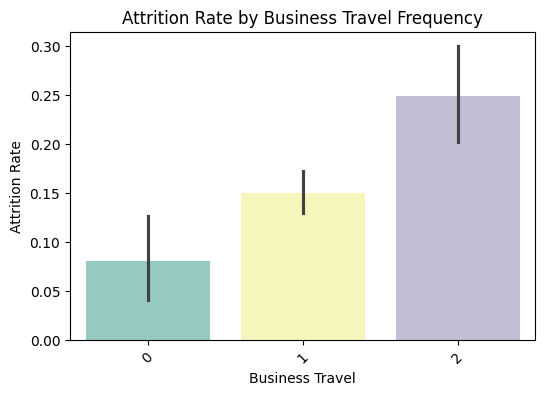

In [29]:
plt.figure(figsize=(6, 4))
sns.barplot(x='BusinessTravel', y='Attrition', data=df, palette='Set3')
plt.title('Attrition Rate by Business Travel Frequency')
plt.xlabel('Business Travel')
plt.ylabel('Attrition Rate')
plt.xticks(rotation=45)
plt.show()

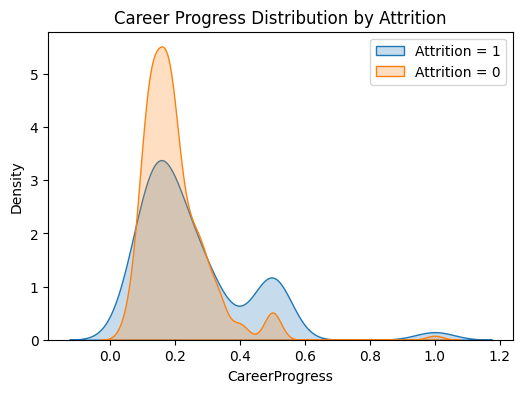

In [30]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=df[df['Attrition']==1], x='CareerProgress', label='Attrition = 1', fill=True)
sns.kdeplot(data=df[df['Attrition']==0], x='CareerProgress', label='Attrition = 0', fill=True)
plt.title('Career Progress Distribution by Attrition')
plt.legend()
plt.show()

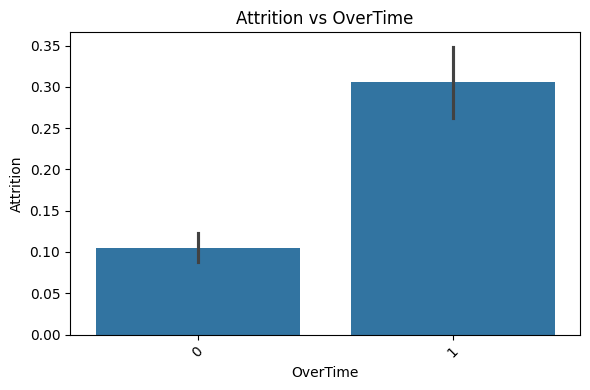

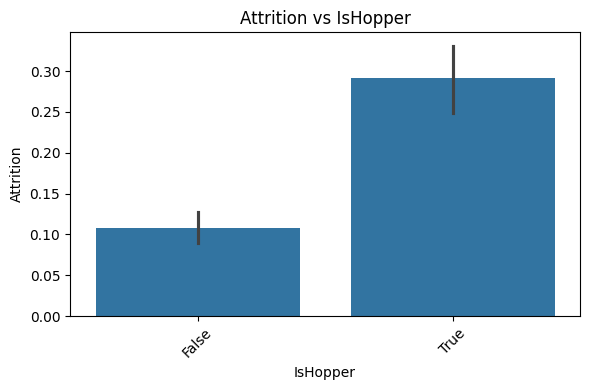

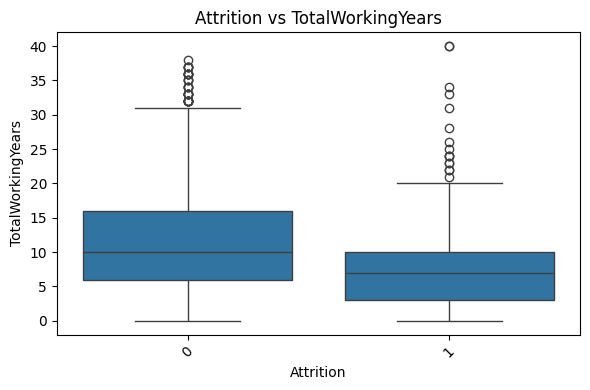

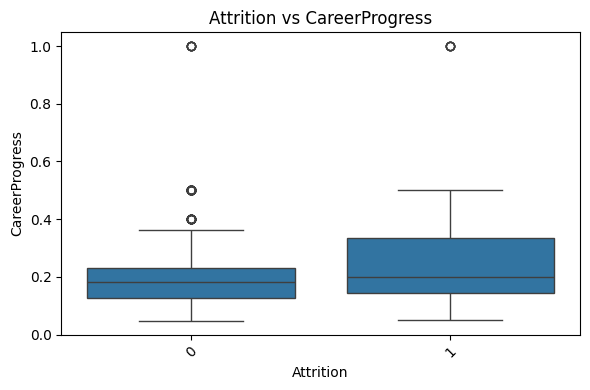

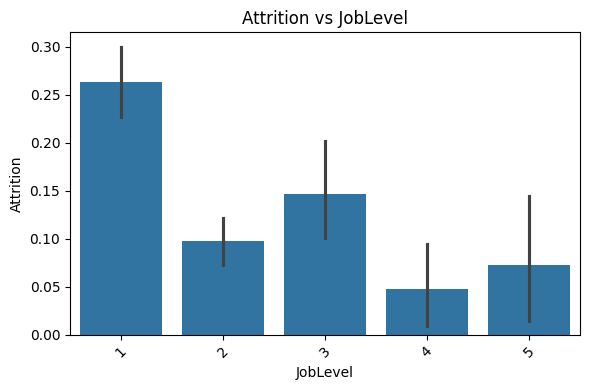

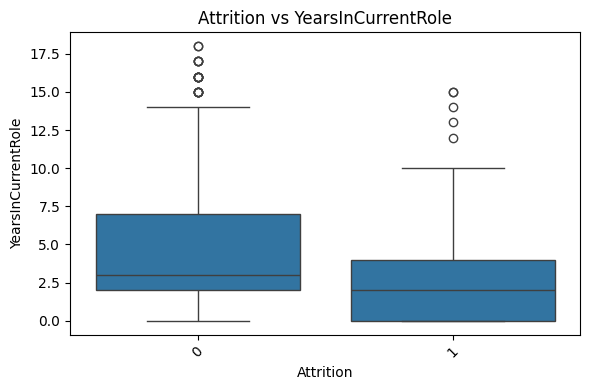

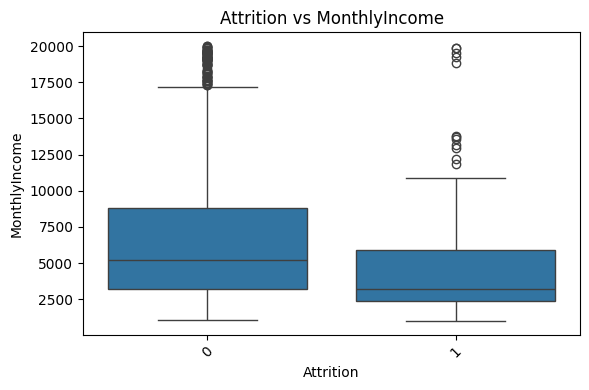

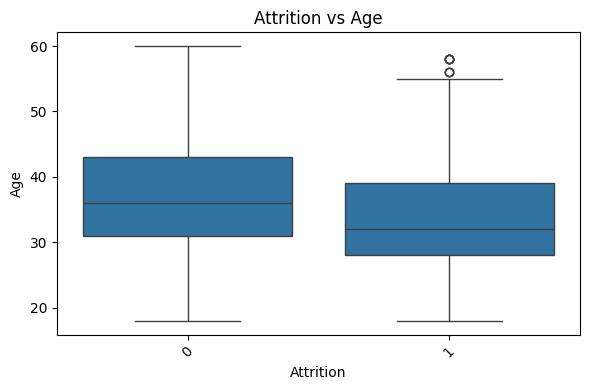

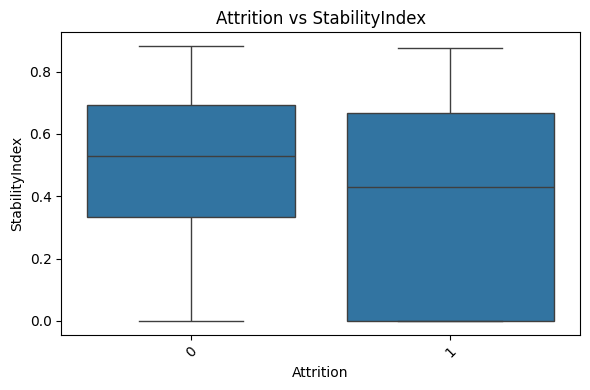

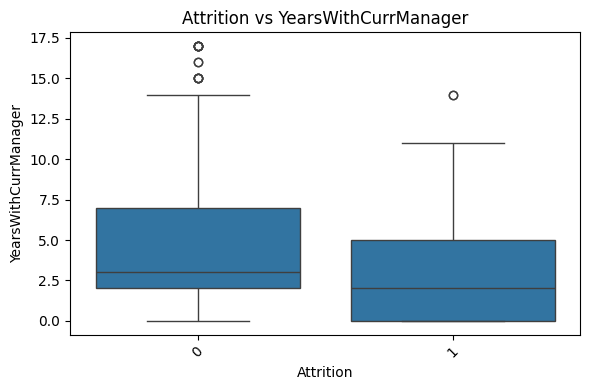

In [31]:
top_corr_features = df.corr(numeric_only=True)['Attrition'].drop('Attrition').abs().sort_values(ascending=False).head(10).index

for feature in top_corr_features:
    plt.figure(figsize=(6, 4))
    if df[feature].nunique() <= 10:
        sns.barplot(x=feature, y='Attrition', data=df)
    else:
        sns.boxplot(x='Attrition', y=feature, data=df)
    plt.title(f'Attrition vs {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [32]:
from scipy.stats import chi2_contingency

# Dictionary to store results
chi2_results = []

# Run chi-square test for each column
for feature in top_corr_features:
    # Create contingency table
    table = pd.crosstab(df[feature], df['Attrition'])

    # Run Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(table)

    # Store result
    chi2_results.append({'Feature': feature, 'Chi2 Stat': round(chi2, 2), 'p-value': round(p, 4)})

# Convert results to a DataFrame
chi2_df = pd.DataFrame(chi2_results)
chi2_df.sort_values(by='p-value', inplace=True)

# Display results
print(chi2_df)

                Feature  Chi2 Stat  p-value
0              OverTime      87.56   0.0000
1              IsHopper      73.45   0.0000
2     TotalWorkingYears     122.30   0.0000
3        CareerProgress     152.55   0.0000
4              JobLevel      72.53   0.0000
5    YearsInCurrentRole      64.30   0.0000
7                   Age     119.17   0.0000
9  YearsWithCurrManager      74.62   0.0000
8        StabilityIndex     135.78   0.1257
6         MonthlyIncome    1319.02   0.7086


## HR Attrition Analysis

The Chi-Square test was conducted between selected categorical and ordinal features and the target variable `Attrition` to evaluate the strength of association.

### Key Findings:

| Feature               | Chi2 Statistic | p-value | Insight |
|-----------------------|----------------|---------|---------|
| OverTime              | 87.56          | 0.0000  | Strong relationship with Attrition. Likely to be a significant predictor. |
| IsHopper              | 73.45          | 0.0000  | Strong association with Attrition. May indicate job-hopping patterns. |
| TotalWorkingYears     | 122.30         | 0.0000  | Significant association with Attrition trends. |
| CareerProgress        | 152.55         | 0.0000  | Very strong link to Attrition, reflects growth opportunities. |
| JobLevel              | 72.53          | 0.0000  | Strong association, as job seniority affects attrition risk. |
| YearsInCurrentRole    | 64.30          | 0.0000  | Indicates stagnation or lack of growth may affect attrition. |
| Age                   | 119.17         | 0.0000  | Age has a strong influence on attrition probability. |
| YearsWithCurrManager  | 74.62          | 0.0000  | Strong relation; manager relationship might impact retention. |
| StabilityIndex        | 135.78         | 0.1257  | High Chi2 but **p-value > 0.05**, not statistically significant. |
| MonthlyIncome         | 1319.02        | 0.7086  | Despite a high statistic, the **very high p-value** suggests no real association. |

---

### Interpretation:

- Features with **p-value < 0.05** show statistically significant relationships with Attrition.
- **OverTime, CareerProgress, IsHopper, and JobLevel** are among the most impactful predictors.
- Features like **StabilityIndex** and **MonthlyIncome** may **not be good indicators** of attrition in this data.

---

These results help prioritize features when building predictive models and conducting further analysis.


In [33]:
df.describe()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,YearsAtOtherCompanies,SatisfactionLevel,CareerProgress,StabilityIndex,AvgTenurePerCompany
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,1.086395,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,...,2.761224,7.008163,4.229252,2.187755,4.123129,4.271429,8.162585,0.206750,0.480701,4.193478
std,9.135373,0.367863,0.532170,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,...,0.706476,6.126525,3.623137,3.222430,3.568136,6.179783,1.884721,0.122469,0.274128,4.035504
min,18.000000,0.000000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.047619,0.000000,0.000000
25%,30.000000,0.000000,1.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,...,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000,7.000000,0.125000,0.333333,1.600000
50%,36.000000,0.000000,1.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,...,3.000000,5.000000,3.000000,1.000000,3.000000,2.000000,8.000000,0.181818,0.500000,3.000000
75%,43.000000,0.000000,1.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,...,3.000000,9.000000,7.000000,3.000000,7.000000,5.000000,10.000000,0.250000,0.666667,5.000000
max,60.000000,1.000000,2.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,...,4.000000,40.000000,18.000000,15.000000,17.000000,33.000000,12.000000,1.000000,0.882353,38.000000


In [34]:
df.head(2)

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,SatisfactionLevel,AgeBucket,CareerProgress,StabilityIndex,AvgTenurePerCompany,IsHopper,IsRecentJoiner,IsHopper_RecentJoiner,Department_Research & Development,Department_Sales
0,41,1,1,1102,1,2,Life Sciences,1,1,2,...,7,3,0.222222,0.571429,0.888889,True,False,False,False,True
1,49,0,2,279,8,1,Life Sciences,1,2,3,...,9,3,0.181818,0.636364,5.000000,False,False,False,True,False


In [35]:
# Convert True/False to int (for IsHopper, IsRecentJoiner, etc.)
binary_cols = ['IsHopper', 'IsRecentJoiner', 'IsHopper_RecentJoiner',
               'Department_Research & Development', 'Department_Sales']
df[binary_cols] = df[binary_cols].astype(int)

# Drop non-numeric columns or encode them
df = pd.get_dummies(df, columns=['EducationField', 'AgeBucket', 'BusinessTravel'], drop_first=True)

# Drop unneeded columns (if any)
df.drop(['EmployeeNumber', 'EmployeeCount'], axis=1, inplace=True)

In [37]:
# Check for object (non-numeric) columns
print(df.select_dtypes(include=['object']).columns)

Index(['Gender', 'JobRole', 'MaritalStatus', 'Over18'], dtype='object')


In [38]:
df = pd.get_dummies(df, columns=['Gender', 'JobRole', 'MaritalStatus', 'Over18'], drop_first=True)


In [39]:
print(df.select_dtypes(include=['object']).columns)

Index([], dtype='object')


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('Attrition', axis=1)
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Define X and y
X = df.drop('Attrition', axis=1)
y = df['Attrition']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Select numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Build scaler transformer
scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'  # leave other columns as-is
)

In [43]:
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', scaler),
        ('model', LogisticRegression(max_iter=1000))
    ]),
    'Support Vector Machine': Pipeline([
        ('scaler', scaler),
        ('model', SVC(probability=True))
    ]),
    'Random Forest': Pipeline([
        ('model', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
}

In [44]:
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    print(f"\n📊 {name} Results:")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))
    print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


📊 Logistic Regression Results:
[[239   8]
 [ 33  14]]
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       247
           1       0.64      0.30      0.41        47

    accuracy                           0.86       294
   macro avg       0.76      0.63      0.66       294
weighted avg       0.84      0.86      0.84       294

AUC Score: 0.8121

📊 Support Vector Machine Results:
[[244   3]
 [ 39   8]]
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       247
           1       0.73      0.17      0.28        47

    accuracy                           0.86       294
   macro avg       0.79      0.58      0.60       294
weighted avg       0.84      0.86      0.82       294

AUC Score: 0.8108

📊 Random Forest Results:
[[241   6]
 [ 42   5]]
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.45      0.11      

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:42:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [45]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_smote.value_counts()}")

Before SMOTE: Attrition
0    986
1    190
Name: count, dtype: int64
After SMOTE: Attrition
0    986
1    986
Name: count, dtype: int64


In [56]:
import joblib

#  Define pipelines and grids
models = {
    'Logistic Regression': (
        Pipeline([('scaler', StandardScaler()),
                  ('model', LogisticRegression(solver='liblinear', random_state=42))]),
        {
            'model__C': [0.01, 0.1, 1, 10],
            'model__penalty': ['l1', 'l2'],
            'model__class_weight': [None, 'balanced']
        }
    ),
    'Random Forest': (
        Pipeline([('model', RandomForestClassifier(random_state=42))]),
        {
            'model__n_estimators': [100, 200],
            'model__max_depth': [5, 10, None],
            'model__class_weight': [None, 'balanced']
        }
    ),
    'XGBoost': (
        Pipeline([('model', XGBClassifier(eval_metric='logloss',
                                          use_label_encoder=False,
                                          random_state=42))]),
        {
            'model__n_estimators': [100, 200],
            'model__max_depth': [3, 6],
            'model__learning_rate': [0.01, 0.1]
        }
    ),
    'SVM': (
        Pipeline([('scaler', StandardScaler()),
                  ('model', SVC(probability=True, random_state=42))]),
        {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__class_weight': [None, 'balanced']
        }
    )
}

best_auc = 0
best_model_name = None
best_model_pipeline = None

for name, (pipeline, param_grid) in models.items():
    print(f"\n===== {name} =====")
    grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train_smote, y_train_smote)

    best = grid.best_estimator_
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    print("Best params:", grid.best_params_)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("AUC Score:", auc)

    # Track best model
    if auc > best_auc:
        best_auc = auc
        best_model_name = name
        best_model_pipeline = best

print(f"\n🏆 Best model: {best_model_name} with AUC: {best_auc:.4f}")

# Save full pipeline
joblib.dump(best_model_pipeline, "best_model_pipeline.pkl")


===== Logistic Regression =====
Best params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2'}
Confusion Matrix:
 [[234  13]
 [ 29  18]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       247
           1       0.58      0.38      0.46        47

    accuracy                           0.86       294
   macro avg       0.74      0.67      0.69       294
weighted avg       0.84      0.86      0.84       294

AUC Score: 0.8177276251184427

===== Random Forest =====
Best params: {'model__class_weight': None, 'model__max_depth': None, 'model__n_estimators': 100}
Confusion Matrix:
 [[232  15]
 [ 36  11]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       247
           1       0.42      0.23      0.30        47

    accuracy                           0.83       294
   macro avg       0.64      0.59      0.60       29

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:08:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best params: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}
Confusion Matrix:
 [[235  12]
 [ 34  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       247
           1       0.52      0.28      0.36        47

    accuracy                           0.84       294
   macro avg       0.70      0.61      0.64       294
weighted avg       0.82      0.84      0.82       294

AUC Score: 0.7859419415970367

===== SVM =====
Best params: {'model__C': 1, 'model__class_weight': None, 'model__kernel': 'rbf'}
Confusion Matrix:
 [[240   7]
 [ 34  13]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       247
           1       0.65      0.28      0.39        47

    accuracy                           0.86       294
   macro avg       0.76      0.62      0.65       294
weighted avg       0.84      0.86      0.84   

['best_model_pipeline.pkl']